In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
import datetime as dt
import statsmodels.formula.api as smf
import geopandas
import geocoder

In [2]:
#Webscraping Singapore's inflation data from rateinflation.com
inflation_df = pd.read_html(requests.get('https://www.rateinflation.com/inflation-rate/singapore-historical-inflation-rate/').text)

#Select inflation data
inflation_df = inflation_df[0]

#Get data from 2017-2022 in reverse order
inflation_df = inflation_df.loc[5::-1]

#Create values for x-axis for months
months = pd.period_range("2017-01", "2022-09" , freq='M').to_timestamp()

#Append inflation data to a list
lst = []
annual = []
for i in inflation_df.to_numpy():
    #Getting only monthly inflation rate from data table
    lst.extend(i[1:-1])
    annual.append(i[-1])


#Removing last 3 months in 2022 because no data yet
lst = lst[:-3]

#Removing % from the inflation data and changing data type to float
lst = [float(i[:-1]) for i in lst]

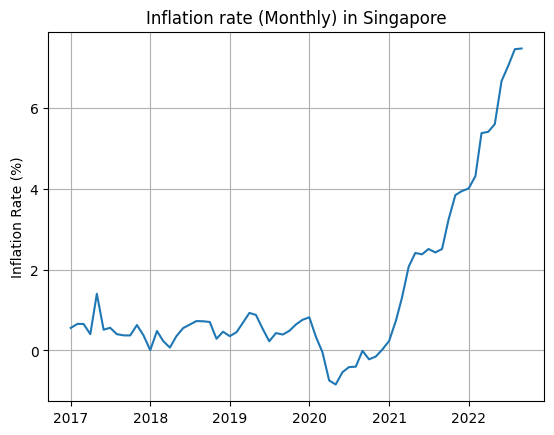

In [3]:
#Plotting the inflation rate in Singapore
plt.plot(months,lst)
plt.ylabel("Inflation Rate (%)")
plt.title("Inflation rate (Monthly) in Singapore")
plt.grid((0.9,0.9,0.9))

In [4]:
DATA_DIR = "Data"

RESIDENTIAL_CSV = f"{DATA_DIR}/ExecutiveCondoTransaction.csv"
COMMERCIAL_CSV = F"{DATA_DIR}/OfficeTransaction.csv"
INDUSTRIAL_CSV = F"{DATA_DIR}/WarehouseTransaction.csv"

In [5]:
residential_df:pd.DataFrame = pd.read_csv(RESIDENTIAL_CSV)
commercial_df:pd.DataFrame = pd.read_csv(COMMERCIAL_CSV)
industrial_df:pd.DataFrame = pd.read_csv(INDUSTRIAL_CSV)

ALL_DFS = {
    "residential": residential_df,
    "commercial": commercial_df,
    "industrial": industrial_df
}

for df_name in ALL_DFS:
    df = ALL_DFS[df_name]
    df = df.dropna()
    df["Sale Date"] = pd.DatetimeIndex(df["Sale Date"]).year

    df["Unit Price ($ PSF)"] = df["Unit Price ($ PSF)"].replace(",", "", regex=True)
    df["Unit Price ($ PSF)"] = pd.to_numeric(df["Unit Price ($ PSF)"], errors = 'coerce')
    ALL_DFS[df_name] = df


In [18]:
all_dfs_groupby_sale_date = {}
for df_name in ALL_DFS:
    all_dfs_groupby_sale_date[df_name] = ALL_DFS[df_name].groupby("Sale Date").mean(numeric_only = True)

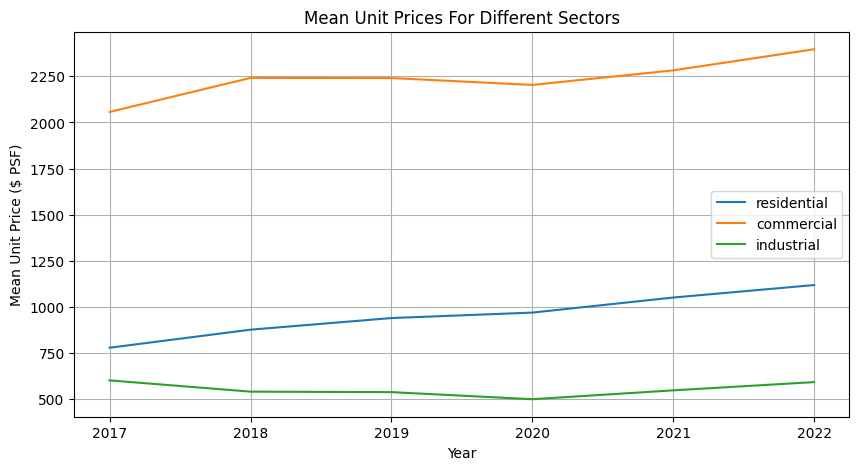

In [19]:
plt.figure(figsize=(10,5))
for i, df_name in enumerate(all_dfs_groupby_sale_date):
    y = all_dfs_groupby_sale_date[df_name]["Unit Price ($ PSF)"]
    # df = ALL_DFS[df_name].mean()
    # y = df.groupby("Sale Date").mean()["Unit Price ($ PSF)"]
    plt.plot(y, label=df_name)
    plt.legend()
    
plt.title('Mean Unit Prices For Different Sectors')
plt.xlabel('Year')
plt.ylabel('Mean Unit Price ($ PSF)')
plt.grid()
plt.show()


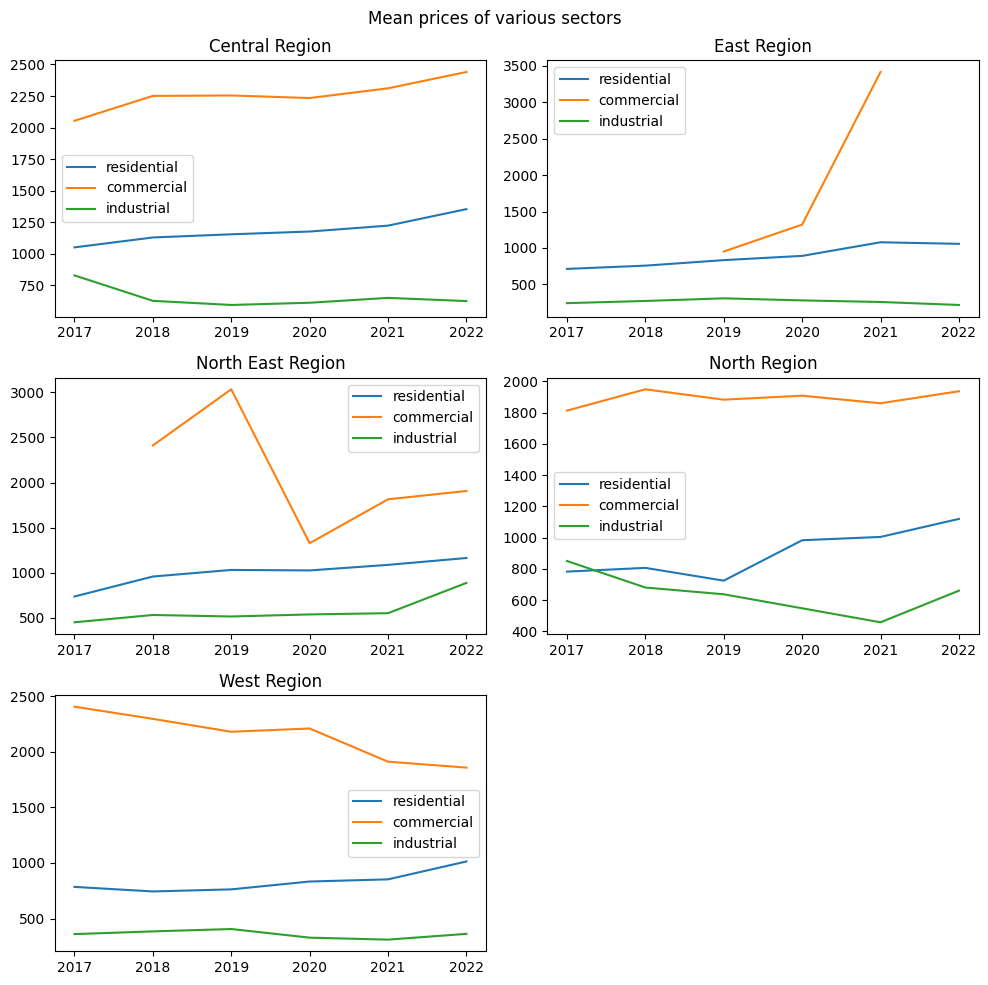

In [41]:
planning_regions = [
    "Central Region",
    "East Region",
    "North East Region",
    "North Region",
    "West Region"
]
n_rows = 3
n_columns = 2   

fig, axs = plt.subplots(n_rows, n_columns, figsize = (10,10))
fig.suptitle('Mean prices of various sectors')

for subplot_index, planning_region in enumerate(planning_regions):
    row = subplot_index//n_columns
    column = subplot_index % n_columns
    
    for i, df_name in enumerate(ALL_DFS):
        sector_df = ALL_DFS[df_name]
        df = sector_df.loc[sector_df["Planning Region"] == planning_region]
        df = df.groupby("Sale Date").mean(numeric_only = True)
        y = df["Unit Price ($ PSF)"]
        
        subplot = axs[row, column]
        subplot.plot(y, label=df_name)
        subplot.title.set_text(planning_region)
        subplot.legend()

if num_empty_plots := (n_rows * n_columns) - len(planning_regions):
    for i in range(num_empty_plots):
        fig.delaxes(axs[-1,-1-i])

plt.tight_layout()
plt.show()


In [9]:
ALL_DFS["residential"].head()

,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Address,Type of Sale,Type of Area,Area (SQM),Unit Price ($ PSM),...,Property Type,Number of Units,Tenure,Completion Date,Purchaser Address Indicator,Postal Code,Postal District,Postal Sector,Planning Region,Planning Area
0,BLOSSOM RESIDENCES,"750,000",753.48,995,2019,30 SEGAR ROAD #04-01,Resale,Strata,70,"10,714",...,Executive Condominium,1,99 yrs from 02/03/2011,2014,Private,677721,23,67,West Region,Bukit Panjang
1,PIERMONT GRAND,"1,478,400","1,334.74",1108,2019,26 SUMANG WALK #05-11,New Sale,Strata,124,"11,923",...,Executive Condominium,1,99 yrs from 04/06/2018,Uncompleted,HDB,828618,19,82,North East Region,Punggol
2,AUSTVILLE RESIDENCES,"860,000","1,033.34",832,2019,19 SENGKANG EAST AVENUE #05-19,Resale,Strata,96,"8,958",...,Executive Condominium,1,99 yrs from 24/08/2010,2014,Private,544808,19,54,North East Region,Sengkang
3,RIVERPARC RESIDENCE,"995,000","1,076.40",924,2019,96 PUNGGOL DRIVE #13-15,Resale,Strata,100,"9,950",...,Executive Condominium,1,99 yrs from 27/12/2010,2014,HDB,828797,19,82,North East Region,Punggol
4,PIERMONT GRAND,"1,680,200","1,506.96",1115,2019,26 SUMANG WALK #07-10,New Sale,Strata,140,"12,001",...,Executive Condominium,1,99 yrs from 04/06/2018,Uncompleted,HDB,828618,19,82,North East Region,Punggol


In [10]:
display(sector_df = ALL_DFS["residential"].head())
# sector_df["Planning Region"].head()

In [11]:
residential_df.head()

,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Address,Type of Sale,Type of Area,Area (SQM),Unit Price ($ PSM),...,Property Type,Number of Units,Tenure,Completion Date,Purchaser Address Indicator,Postal Code,Postal District,Postal Sector,Planning Region,Planning Area
0,BLOSSOM RESIDENCES,"750,000",753.48,995,1-Oct-19,30 SEGAR ROAD #04-01,Resale,Strata,70,"10,714",...,Executive Condominium,1,99 yrs from 02/03/2011,2014,Private,677721,23,67,West Region,Bukit Panjang
1,PIERMONT GRAND,"1,478,400","1,334.74","1,108",1-Oct-19,26 SUMANG WALK #05-11,New Sale,Strata,124,"11,923",...,Executive Condominium,1,99 yrs from 04/06/2018,Uncompleted,HDB,828618,19,82,North East Region,Punggol
2,AUSTVILLE RESIDENCES,"860,000","1,033.34",832,1-Oct-19,19 SENGKANG EAST AVENUE #05-19,Resale,Strata,96,"8,958",...,Executive Condominium,1,99 yrs from 24/08/2010,2014,Private,544808,19,54,North East Region,Sengkang
3,RIVERPARC RESIDENCE,"995,000","1,076.40",924,2-Oct-19,96 PUNGGOL DRIVE #13-15,Resale,Strata,100,"9,950",...,Executive Condominium,1,99 yrs from 27/12/2010,2014,HDB,828797,19,82,North East Region,Punggol
4,PIERMONT GRAND,"1,680,200","1,506.96","1,115",2-Oct-19,26 SUMANG WALK #07-10,New Sale,Strata,140,"12,001",...,Executive Condominium,1,99 yrs from 04/06/2018,Uncompleted,HDB,828618,19,82,North East Region,Punggol


In [12]:
for df in ALL_DFS.values():
    print(df)
    break

               Project Name Transacted Price ($) Area (SQFT)  \
0        BLOSSOM RESIDENCES              750,000      753.48   
1            PIERMONT GRAND            1,478,400    1,334.74   
2      AUSTVILLE RESIDENCES              860,000    1,033.34   
3       RIVERPARC RESIDENCE              995,000    1,076.40   
4            PIERMONT GRAND            1,680,200    1,506.96   
...                     ...                  ...         ...   
12112              EASTVALE            1,050,000    1,097.93   
12113                 PRIVE            1,360,000    1,097.93   
12114           THE TERRACE            1,238,000    1,001.05   
12115            1 CANBERRA            1,020,000      947.23   
12116                 PRIVE              990,500      828.83   

       Unit Price ($ PSF)  Sale Date                         Address  \
0                     995       2019            30 SEGAR ROAD #04-01   
1                    1108       2019           26 SUMANG WALK #05-11   
2              

In [13]:
residential_df.head()

,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Address,Type of Sale,Type of Area,Area (SQM),Unit Price ($ PSM),...,Property Type,Number of Units,Tenure,Completion Date,Purchaser Address Indicator,Postal Code,Postal District,Postal Sector,Planning Region,Planning Area
0,BLOSSOM RESIDENCES,"750,000",753.48,995,1-Oct-19,30 SEGAR ROAD #04-01,Resale,Strata,70,"10,714",...,Executive Condominium,1,99 yrs from 02/03/2011,2014,Private,677721,23,67,West Region,Bukit Panjang
1,PIERMONT GRAND,"1,478,400","1,334.74","1,108",1-Oct-19,26 SUMANG WALK #05-11,New Sale,Strata,124,"11,923",...,Executive Condominium,1,99 yrs from 04/06/2018,Uncompleted,HDB,828618,19,82,North East Region,Punggol
2,AUSTVILLE RESIDENCES,"860,000","1,033.34",832,1-Oct-19,19 SENGKANG EAST AVENUE #05-19,Resale,Strata,96,"8,958",...,Executive Condominium,1,99 yrs from 24/08/2010,2014,Private,544808,19,54,North East Region,Sengkang
3,RIVERPARC RESIDENCE,"995,000","1,076.40",924,2-Oct-19,96 PUNGGOL DRIVE #13-15,Resale,Strata,100,"9,950",...,Executive Condominium,1,99 yrs from 27/12/2010,2014,HDB,828797,19,82,North East Region,Punggol
4,PIERMONT GRAND,"1,680,200","1,506.96","1,115",2-Oct-19,26 SUMANG WALK #07-10,New Sale,Strata,140,"12,001",...,Executive Condominium,1,99 yrs from 04/06/2018,Uncompleted,HDB,828618,19,82,North East Region,Punggol


# Regression

In [14]:
regression_residential_df = residential_df[["Transacted Price ($)","Area (SQFT)"]]
regression_residential_df = regression_residential_df.rename(columns={"Transacted Price ($)": "Price", "Area (SQFT)":"Area"})
regression_residential_df["Price"] = regression_residential_df["Price"].replace(",", "", regex=True)
regression_residential_df["Area"] = regression_residential_df["Area"].replace(",", "", regex=True)
regression_residential_df['Price'] = pd.to_numeric(regression_residential_df['Price'], errors = 'coerce')
regression_residential_df['Area'] = pd.to_numeric(regression_residential_df['Area'], errors = 'coerce')
reg1 = smf.ols("Price ~ Area ", data = regression_residential_df).fit()
reg1.params


Intercept    407810.951523
Area            620.415408
dtype: float64

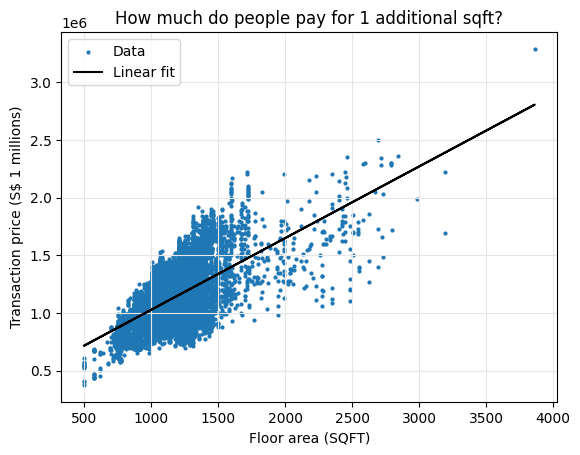

In [15]:
# Linear relationship (Linear trendline)
regression_residential_df['fit_price'] = reg1.params[0] + reg1.params[1]*regression_residential_df['Area']

fig, ax = plt.subplots(1,1)
plt.scatter(regression_residential_df['Area'], regression_residential_df['Price'],s=4, label = 'Data')
plt.plot(regression_residential_df['Area'],regression_residential_df['fit_price'],color=(0,0,0), label = 'Linear fit')
plt.title('How much do people pay for 1 additional sqft?')
plt.xlabel('Floor area (SQFT)')
plt.ylabel('Transaction price (S$ 1 millions)')
plt.legend()
plt.grid(color=(.9,.9,.9))
plt.show()


# Map

Credit:\
Running Onemap API to obtain lat and long data from postal code: https://xang1234.github.io/bubbleproperty/ \
Converting csv to GeoDataFrame: https://www.kaggle.com/code/ujwalkandi/mapping-postal-codes-singapore \
Map of Singapore: https://maps.princeton.edu/catalog/stanford-pg798kr1205 


In [16]:
# Extracting Unit Price ($ PSF) > 1000 data and Postal Code data from residential dataframe
map_df = residential_df[["Unit Price ($ PSF)", "Postal Code"]]
map_df["Price"] = map_df["Unit Price ($ PSF)"].replace(",", "", regex=True)
map_df['Price'] = pd.to_numeric(map_df['Price'], errors = 'coerce')
map_df = map_df.loc[map_df['Price']>1000]
map_df = map_df.reset_index(drop=True)

C:\Users\JevanGoh\AppData\Local\Temp\ipykernel_21604\2902514914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_df["Price"] = map_df["Unit Price ($ PSF)"].replace(",", "", regex=True)
C:\Users\JevanGoh\AppData\Local\Temp\ipykernel_21604\2902514914.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_df['Price'] = pd.to_numeric(map_df['Price'], errors = 'coerce')


In [17]:
import time
import simplejson as json

ModuleNotFoundError: No module named 'simplejson'

In [ ]:
# Running postal codes through OneMap API to get latitude and longitude of buildings
# Takes long to run (Around 250 entries per min), so highly recommended to save to another file when done. 
# Saved to mapdata.csv in this case
for i in range(len(map_df)):
    if len(str(map_df['Postal Code'][i]))==5:
        map_df['Postal Code'][i]='0'+map_df['Postal Code'][i]
        
map_df['OnemapLongitude'] = pd.Series(0, index=map_df.index)
map_df['OnemapLatitude'] = pd.Series(0, index=map_df.index)       
map_df['Postal Code'] = map_df['Postal Code'].astype(str)

start=time.time()
for i in range(len(map_df)):
    req=requests.get('https://developers.onemap.sg/commonapi/search?searchVal='+map_df['Postal Code'][i]+'&returnGeom=Y&getAddrDetails=Y&pageNum=1')
    jdata = json.loads(req.text)
    if jdata['found']>=1:
        map_df['OnemapLongitude'][i]=jdata['results'][0]['LONGITUDE']
        map_df['OnemapLatitude'][i]=jdata['results'][0]['LATITUDE']
    else:
        map_df['OnemapLongitude'][i]=float('nan')
        map_df['OnemapLatitude'][i]=float('nan')
    print(f"{i}/{len(map_df)}")
    
print('Time Taken:',time.time()-start)
map_df.to_csv("Data/mapdata.csv")

In [ ]:
# Read latitude and longitude data from generated csv and convert the format into epsg:4326 latitude/longitude coordinate system
df_codes = geopandas.read_file('Data/mapdata.csv')
df = geopandas.GeoDataFrame(df_codes, geometry=geopandas.points_from_xy(df_codes["OnemapLongitude"].astype('float32'), df_codes["OnemapLatitude"].astype('float32')) )
df.crs = {'init': 'epsg:4326'}

# Read the Singapore map
gf0 = geopandas.read_file('zip://data/stanford-pg798kr1205-shapefile.zip')


d:\Anaconda\envs\re2708\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


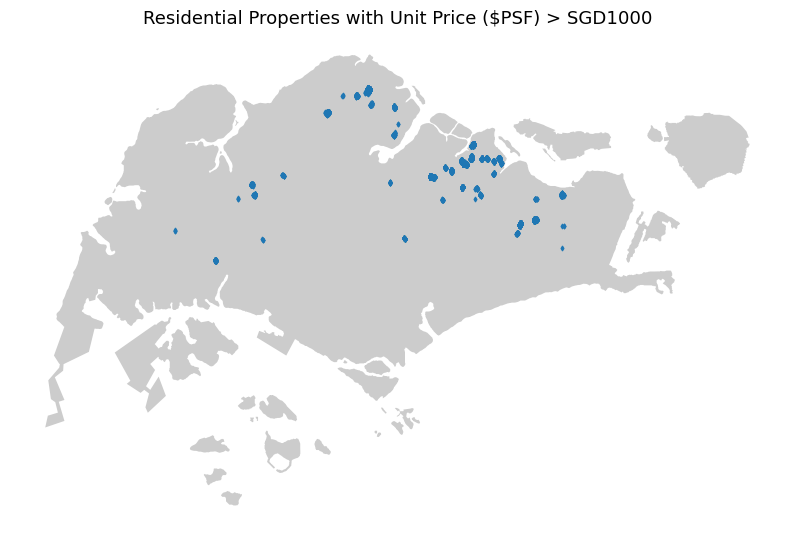

In [ ]:
# Plotting the map figure
fig, axis = plt.subplots(1,1,figsize=(10,10))
gf0.plot(ax=axis, color=(.8,.8,.8))
df.plot(ax = axis,marker='d',markersize=5)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('Residential Properties with Unit Price ($PSF) > SGD1000',fontsize=13)
plt.show()

# Extra Codes

In [ ]:
#Webscraping Singapore's inflation data from macrotrends.net
inflation_df2 = pd.read_html(requests.get('https://www.macrotrends.net/countries/SGP/singapore/inflation-rate-cpi').text)

#Selecting the correct dataframe
inflation_df2 = inflation_df2[1] 

#Renaming the columns
inflation_df2.columns = ['Year', 'Inflation Rate', 'Annual Change']

#Removing the % in the data of Inflation Rate and Annual Change
inflation_df2 = inflation_df2.replace("%","", regex = True)

#Changing all values in dataframe to numeric data
inflation_df2['Year'] = pd.to_numeric(inflation_df2['Year'], errors = 'coerce')
inflation_df2['Inflation Rate'] = pd.to_numeric(inflation_df2['Inflation Rate'], errors = 'coerce')
inflation_df2['Annual Change'] = pd.to_numeric(inflation_df2['Annual Change'], errors = 'coerce')

#Seeing the dataframe
inflation_df2.head()

,Year,Inflation Rate,Annual Change
0,2021,2.30,2.49
1,2020,-0.18,-0.75
2,2019,0.57,0.13
3,2018,0.44,-0.14
4,2017,0.58,1.11


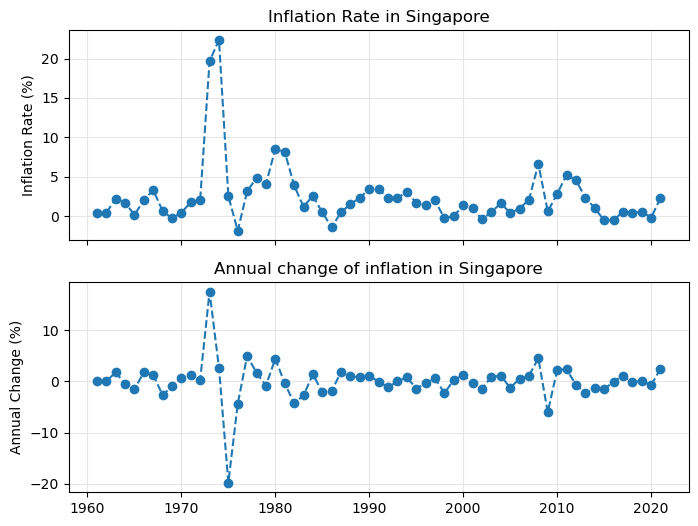

In [ ]:
#Using matplotlib.subplots to plot two figures using webscraped data
#Share the same x axis (Year) for both figures 
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6),sharex=True)

#Plotting Figure 1: Inflation Rate in Singapore
ax1.plot(inflation_df2['Year'],inflation_df2['Inflation Rate'],linestyle='dashed',marker='o',markersize=6)
ax1.set_title('Inflation Rate in Singapore')
ax1.set_ylabel('Inflation Rate (%)')
ax1.grid(color=(.9,.9,.9))

#Plotting Figure 2: Annual change of inflation in Singapore
ax2.plot(inflation_df2['Year'],inflation_df2['Annual Change'],linestyle='dashed',marker='o',markersize=6)
ax2.set_title('Annual change of inflation in Singapore')
ax2.set_ylabel('Annual Change (%)')
ax2.grid(color=(.9,.9,.9))

#Using tight layout to look more pr

In [ ]:
residential_df = pd.read_csv("Data/ExecutiveCondoTransaction.csv")
residential_df = residential_df.replace(",","", regex = True)
residential_df['Unit Price ($ PSF)'] = pd.to_numeric(residential_df['Unit Price ($ PSF)'], errors = 'raise')
residential_df['Sale Date'] = pd.to_datetime(residential_df['Sale Date'], infer_datetime_format=True)
residential_df['Sale MY'] = residential_df['Sale Date'].dt.strftime('%Y %m')
residential_region_df = residential_df.groupby(['Planning Region', 'Sale MY'])

residential_central_df = residential_df.loc[residential_df['Planning Region'] == 'Central Region']
residential_central_df = residential_central_df.sort_values(by='Sale MY')
residential_central_df = residential_central_df.groupby('Sale MY').mean()


C:\Users\Ronald Toh\AppData\Local\Temp\ipykernel_6104\3947075145.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  residential_central_df = residential_central_df.groupby('Sale MY').mean()


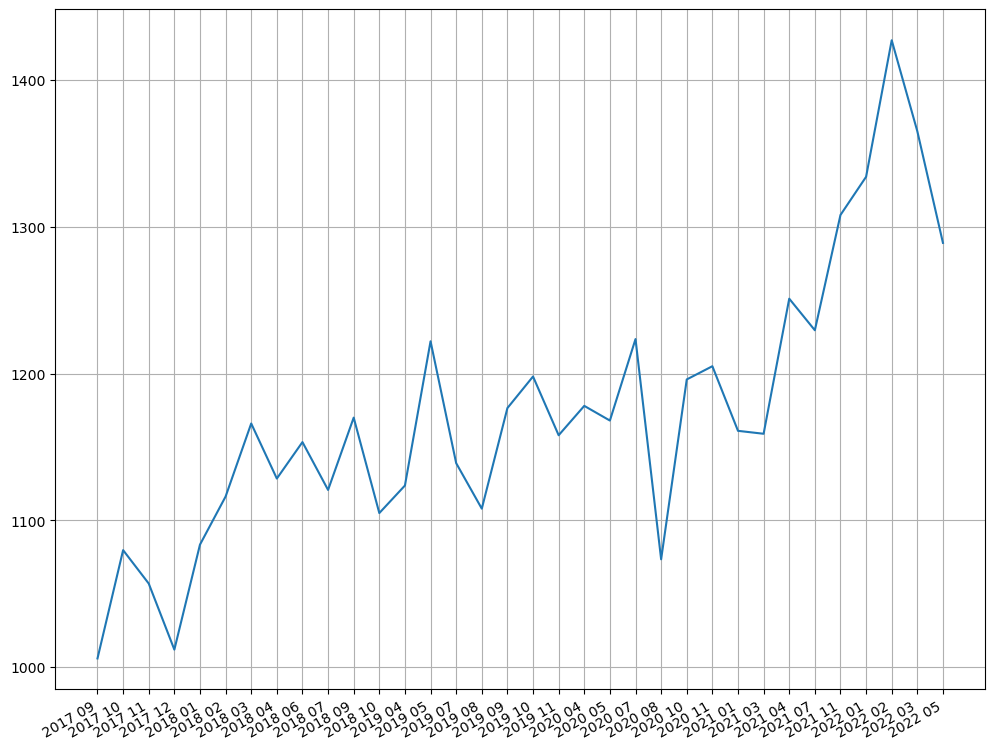

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))

# half_year_locator = mdates.MonthLocator(interval=6)
# ax.xaxis.set_major_locator(half_year_locator) # Locator for major axis only.
fig.autofmt_xdate()
ax.plot(residential_central_df['Unit Price ($ PSF)'])
plt.grid()